total number of frames is 25
entering FuncAnimation call
returned from FuncAnimation call


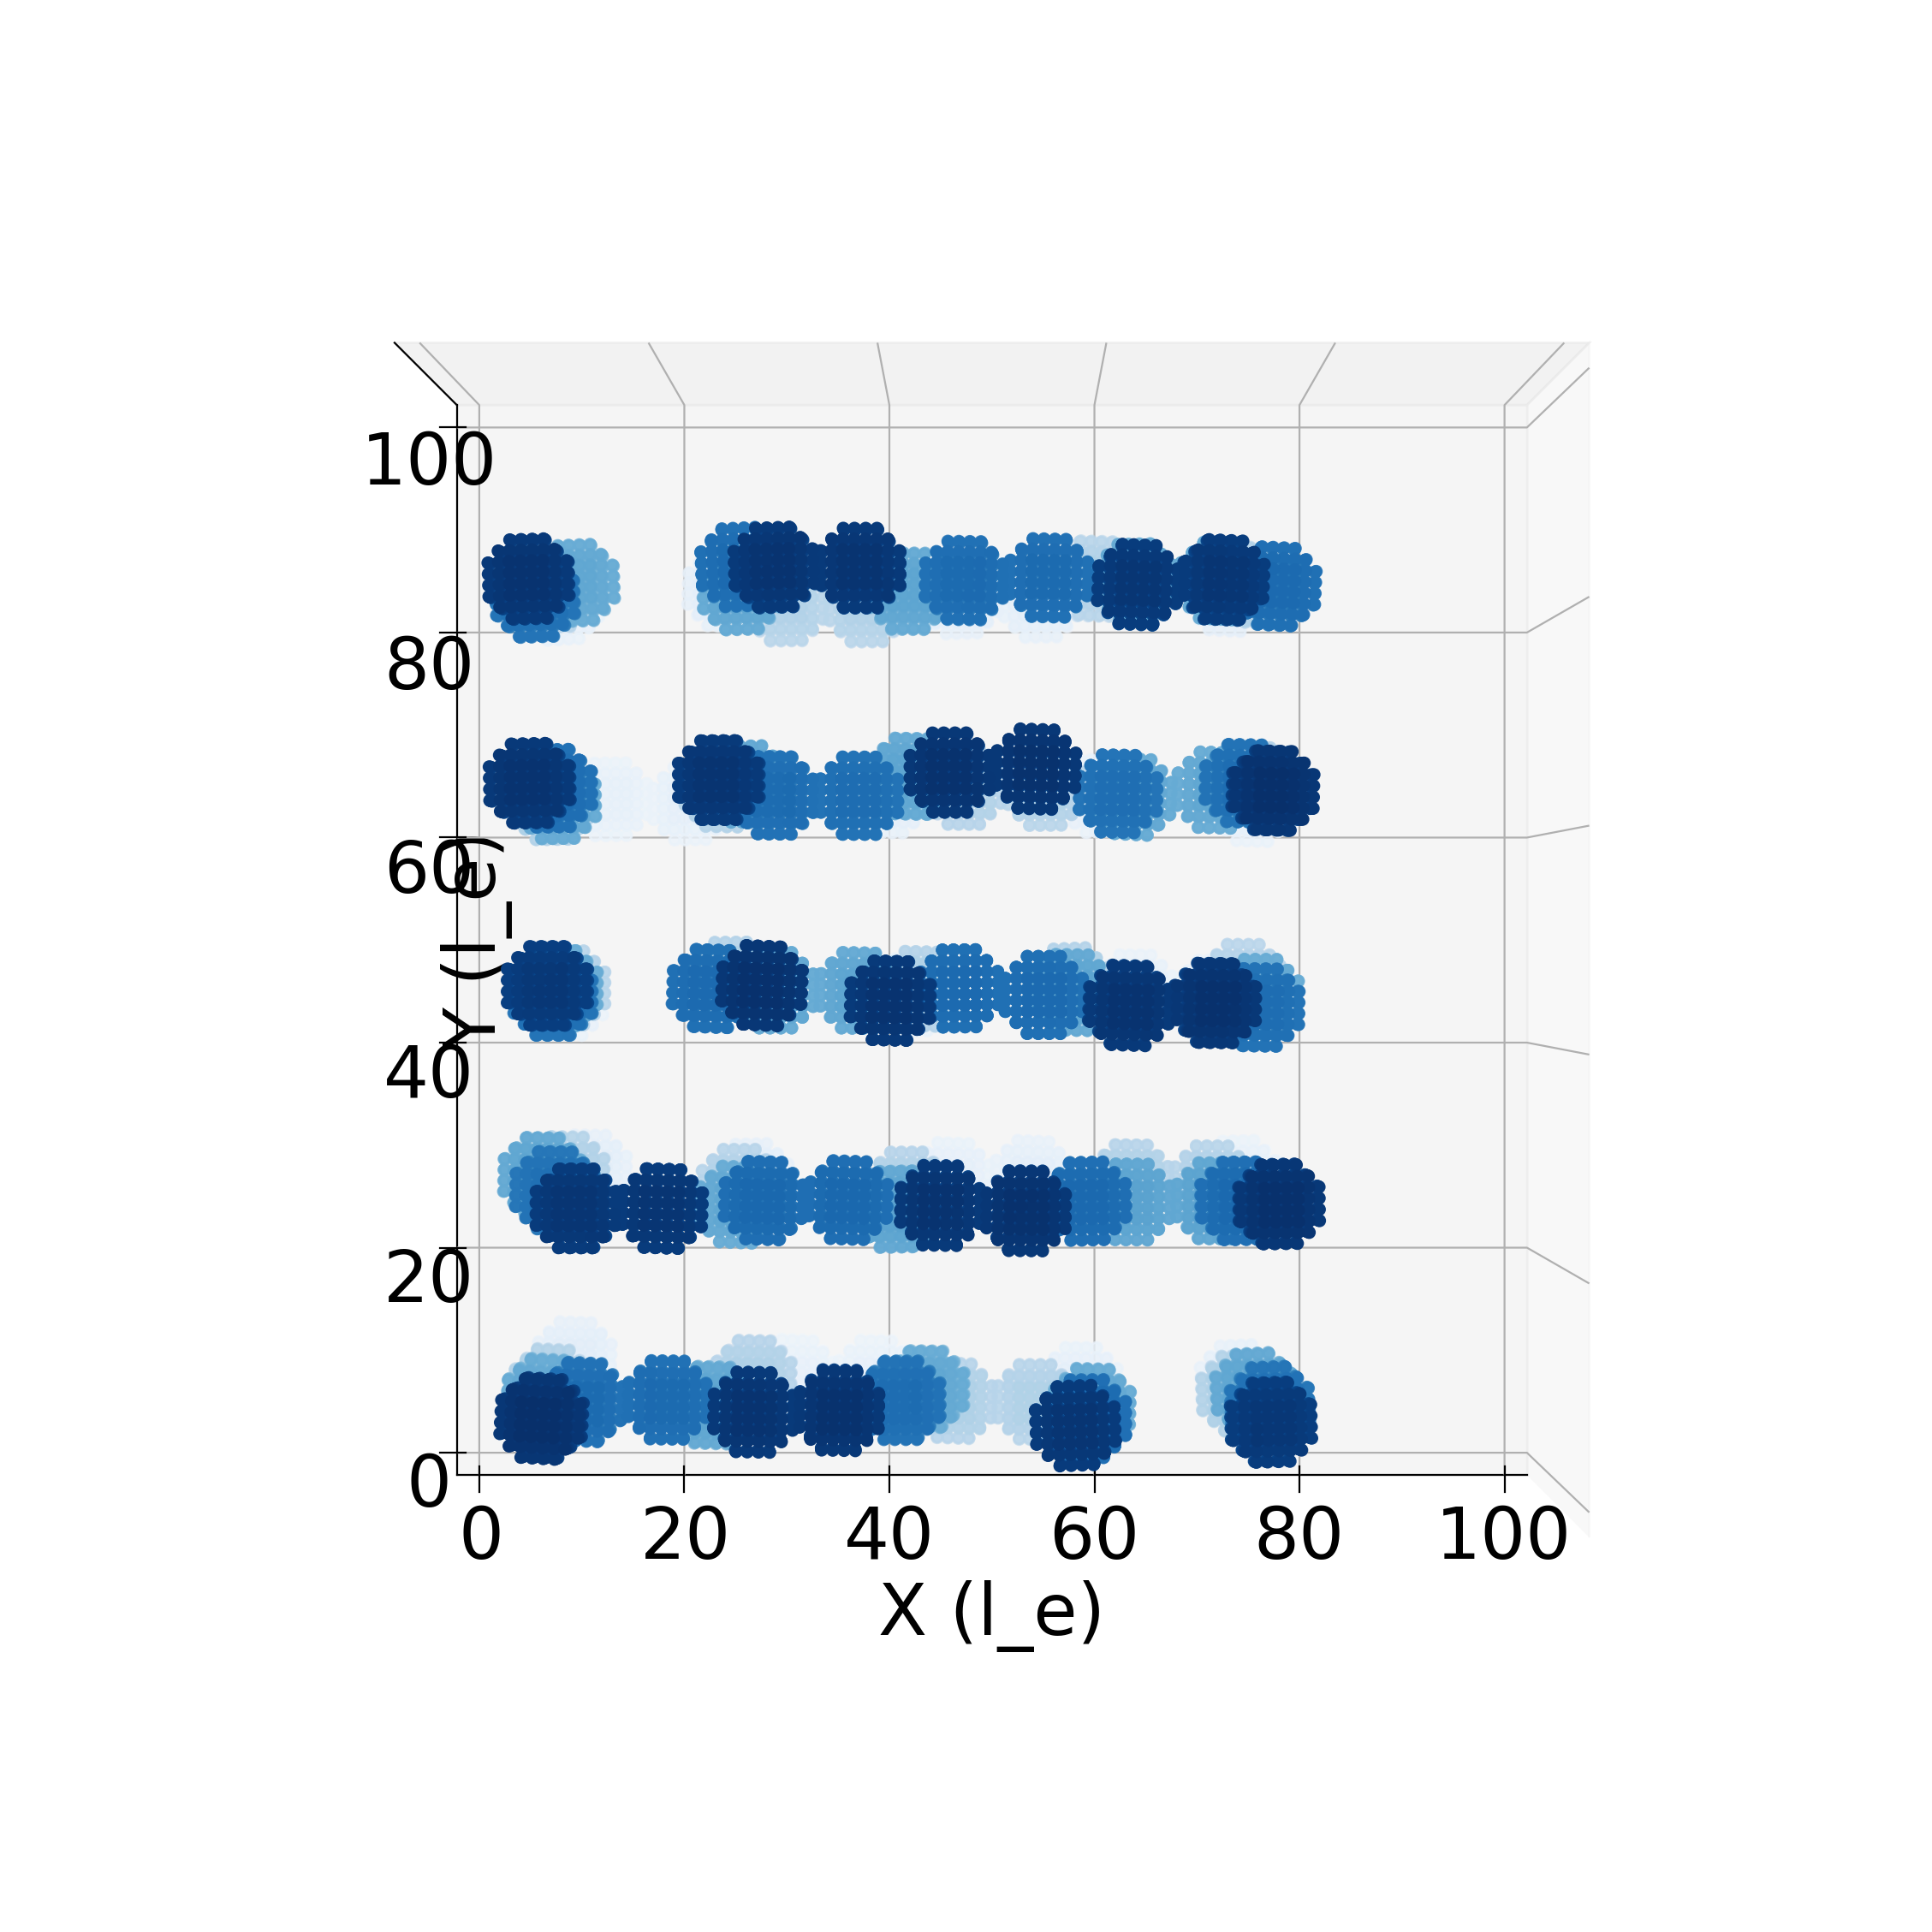

In [19]:
#D Marchfield 2024-05-23
#Animating particle node scatter plots to see evolution of particle positions during the simulation, using checkpoint and output files
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import mre.analyze
import mre.initialize
import os

sim_dir = f"/mnt/c/Users/bagaw/Desktop/MRE/two_particle/2024-05-09_125_particle_field_dependent_modulus_strain_strain_tension_direction('x', 'x')_order_3_E_9000.0_nu_0.47_Bext_angle_0.0_gpu_True_starttime_16-55_stepsize_5.e-3/"
sim_checkpoint_dir = sim_dir + "strain_0_strain_tension_0.0_field_7_Bext_[0.07 0.   0.  ]/"

def plot_particle_nodes(eq_node_posns,node_posns,particles,view,tag=""):
    Lx = eq_node_posns[:,0].max()
    Ly = eq_node_posns[:,1].max()
    Lz = eq_node_posns[:,2].max()
    xlabel = '\nX (l_e)'
    ylabel = '\nY (l_e)'
    zlabel = '\nZ (l_e)'
    axis_limit_max = np.max(np.array([Lx,Ly,Lz]))*1.1
    xlim = (-0.1,axis_limit_max)
    ylim = (-0.1,axis_limit_max)
    zlim = (-0.1,axis_limit_max)
    fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
    default_width,default_height = fig.get_size_inches()
    fig.set_size_inches(3*default_width,3*default_height)
    fig.set_dpi(200)
    particles = np.ravel(particles)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    if view == 'default':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
            tag = "_" + tag
    elif view == 'xy':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,2])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(90,-90,0)
        ax.set_zlabel('')
        ax.set_zticks([])
        ax.set_aspect('equal')
    elif view == 'xz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues_r',c=node_posns[particles,1])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,-90,0)
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_aspect('equal')
    elif view == 'yz':
        ax.scatter(node_posns[particles,0],node_posns[particles,1],node_posns[particles,2],cmap='Blues',c=node_posns[particles,0])
        mre.analyze.format_figure_3D(ax)
        if tag != "":
            ax.set_title(tag)
        ax.view_init(0,0,0)
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.set_aspect('equal')
    return fig, ax

def animate_particle_nodes(sim_dir,sim_checkpoint_dir,view,output_dir,tag=""):
    """Animate a scatter plot showing the nodes making up the particles using output and checkpoint files."""
    #Do basic read in
    eq_node_posns, mass, springs, elements, boundaries, particles, parameters, field_series, boundary_condition_series, sim_type = mre.initialize.read_init_file(sim_dir + 'init.h5')
    #either have user provide the directory of the specific simulation step, or else somehow specify it (the applied strain and the applied field)
    solution, applied_field, boundary_conditions, count = mre.initialize.read_checkpoint_file(sim_checkpoint_dir + 'checkpoint0.h5')
    boundary_conditions = mre.initialize.format_boundary_conditions(boundary_conditions)
    num_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'checkpoint')
    num_output_files = mre.analyze.get_num_named_files(sim_checkpoint_dir,'output')
    #if an extension directory exists, get that too
    if os.path.isdir(sim_checkpoint_dir[:-1] + '_extension/'):
        num_extra_checkpoint_files = mre.analyze.get_num_named_files(sim_checkpoint_dir[:-1] + '_extension/','checkpoint')
    else:
        num_extra_checkpoint_files = 0
    #then read in the necessary first file (if doing a single simulation step, though it is also possible to animate a simulation across multiple steps)
    #find the right output file number to read in and construct the starting frame
    #construct the first figure and keep the handle to the figure and axes, taking into account the user desired view angle
    #use the matplotlib.animation.FuncAnimation class
    #make sure to save the animation
    print(f'total number of frames is {num_checkpoint_files + num_extra_checkpoint_files}')
    num_nodes = eq_node_posns.shape[0]
    node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    fig, ax = plot_particle_nodes(eq_node_posns,node_posns,particles,view,tag)
    particles = np.ravel(particles)
    print('entering FuncAnimation call')
    ani = animation.FuncAnimation(fig=fig,func=update,frames=np.arange(num_checkpoint_files+num_extra_checkpoint_files),interval=500,fargs=(ax,view,sim_checkpoint_dir,num_checkpoint_files,num_extra_checkpoint_files,particles))
    print('returned from FuncAnimation call')
    plt.show()
    return fig, ax, ani

def update(frame,*fargs):
    """Update an existing 3D scatter plot."""
    ax = fargs[0]
    view = fargs[1]
    checkpoint_dir = fargs[2]
    num_checkpoint_files = fargs[3]
    num_extra_checkpoint_files = fargs[4]
    particles = fargs[5]
    #read in the checkpoint file based on the frame number (checking which directory based on the frame number and the num_checkpoint_files and num_extra_checkpoint_files values)
    if frame < num_checkpoint_files:
        solution, _, _, _ = mre.initialize.read_checkpoint_file(sim_checkpoint_dir + f'checkpoint{frame}.h5')
    else:
        solution, _, _, _ = mre.initialize.read_checkpoint_file(sim_checkpoint_dir[:-1] + '_extension/' + f'checkpoint{frame}.h5')
    #reshape the positions variable and update the scatter plot data with set_offsets
    num_nodes = int(np.round(solution.shape[0]/6))
    node_posns = solution[:3*num_nodes].reshape((num_nodes,3))
    new_data = node_posns[particles,:]
    axes_children = ax.get_children()
    scatter_artist = axes_children[0]
    scatter_artist._offsets3d = (new_data[:,0],new_data[:,1],new_data[:,2])
    if view == 'default':
        pass
    # elif view == 'xy':
    #     scatter_artist.set_array(new_data[2])
    # elif view == 'xz':
    #     scatter_artist.set_array(new_data[1])
    # elif view == 'yz':
    #     scatter_artist.set_array(new_data[0])

    return scatter_artist,

fig, ax, ani = animate_particle_nodes(sim_dir,sim_checkpoint_dir,view='xy',output_dir="",tag="")
# plt.show()

ani.save(filename=sim_dir+'test_animation_2.webp',writer="pillow")
